**Kausalanalyse: Bars und Nachtunfälle**

- Propensity Score Matching: Bar-Grids (≥10 Bars) vs Kontrollgrids (≤2 Bars)
- Matching auf Infrastruktur-Features (Straßenlänge, Geschwindigkeit, Spuren, etc.)
- Effektschätzung: Nachtunfälle pro km in Bar-Grids vs strukturell vergleichbaren Kontrollgrids
- Unfalltypen-Vergleich zwischen gematchten Gruppen

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

### Daten & Spatial Join
- Nachtunfälle hier definiert als 0-6 Uhr (nicht 23-5)
- Unfälle per Spatial Join auf Grid Ebene aggregiert

In [17]:
grid_features = pd.read_parquet('grid_features.parquet')
unfaelle = pd.read_parquet('unfaelle_mit_strassen.parquet')

grid_features['geometry'] = grid_features['geometry'].apply(
    lambda x: wkb.loads(x) if isinstance(x, bytes) else x
)
grid_gdf = gpd.GeoDataFrame(grid_features, geometry='geometry', crs='EPSG:25832')

unfaelle_gdf = gpd.GeoDataFrame(
    unfaelle,
    geometry=gpd.points_from_xy(unfaelle['XGCSWGS84'], unfaelle['YGCSWGS84']),
    crs='EPSG:4326'
).to_crs('EPSG:25832')

nacht_unfaelle = unfaelle_gdf[unfaelle_gdf['USTUNDE'].between(0, 6)]  # bewusst 0-6, nicht is_night (23-5)

unfaelle_with_grid = gpd.sjoin(
    nacht_unfaelle,
    grid_gdf[['GridID', 'geometry']],
    how='left',
    predicate='within'
)

night_accidents_per_grid = unfaelle_with_grid.groupby('GridID').size().reset_index(
    name='night_accidents'
)

grid_data = grid_features.drop(columns=['geometry']).merge(
    night_accidents_per_grid,
    on='GridID',
    how='left'
)
grid_data['night_accidents'] = grid_data['night_accidents'].fillna(0).astype(int)

print(f"Grids: {len(grid_data)}, Nachtunfälle: {grid_data['night_accidents'].sum()}")

Grids: 1770, Nachtunfälle: 957


### Propensity Score Matching
- Bar-Grids (≥10 Bars) vs Kontrollgrids (≤2 Bars)
- Optimale Zuordnung mit Caliper (1.5 × SD) damit nur strukturell ähnliche Grids gematcht werden

In [18]:
treatment = grid_data[grid_data['bar_count'] >= 10].copy()
control_pool = grid_data[grid_data['bar_count'] <= 2].copy()

print(f"Bar-Grids (≥10 Bars): {len(treatment)}")
print(f"Kontrollgrids (≤2 Bars): {len(control_pool)}")

matching_features = [
    'road_km',
    'residential_km_share',
    'maxspeed_mean_weighted',
    'lanes_share_ge2',
    'oneway_km_share',
]

Bar-Grids (≥10 Bars): 34
Kontrollgrids (≤2 Bars): 1641


In [19]:
combined = pd.concat([treatment, control_pool], axis=0)
combined['treatment'] = np.where(combined['bar_count'] >= 10, 1, 0)

X = combined[matching_features].fillna(combined[matching_features].median())
y = combined['treatment']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ps_model = LogisticRegression(max_iter=1000, random_state=42)
ps_model.fit(X_scaled, y)
combined['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]

feature_importance = pd.DataFrame({
    'Feature': matching_features,
    'Coefficient': ps_model.coef_[0],
    'Odds_Ratio': np.exp(ps_model.coef_[0])
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"{'Feature':<30} {'Coefficient':>12} {'Odds Ratio':>12}")
for _, row in feature_importance.iterrows():
    print(f"{row['Feature']:<30} {row['Coefficient']:>12.3f} {row['Odds_Ratio']:>12.3f}")

treatment_df = combined[combined['treatment'] == 1].copy().reset_index(drop=False)
control_df = combined[combined['treatment'] == 0].copy().reset_index(drop=False)

treatment_ps = treatment_df['propensity_score'].values.reshape(-1, 1)
control_ps = control_df['propensity_score'].values.reshape(-1, 1)

caliper = 1.5 * combined['propensity_score'].std()  # Standardgrenze für akzeptable PS-Distanz
distances = cdist(treatment_ps, control_ps, metric='euclidean')

cost_matrix = distances.copy()
cost_matrix[cost_matrix > caliper] = 1e10  # zu weit entfernte Paare von der Zuordnung ausschließen

row_ind, col_ind = linear_sum_assignment(cost_matrix)

matches = []
for i, j in zip(row_ind, col_ind):
    if distances[i, j] <= caliper:
        matches.append({
            'treatment_idx': treatment_df.iloc[i]['index'],
            'control_idx': control_df.iloc[j]['index']
        })

matches_df = pd.DataFrame(matches)

matched_treatment = grid_data.loc[matches_df['treatment_idx']]
matched_control = grid_data.loc[matches_df['control_idx']]

print(f"\nMatched: {len(matches_df)}/{len(treatment_df)} ({len(matches_df)/len(treatment_df)*100:.1f}%)")

Feature                         Coefficient   Odds Ratio
maxspeed_mean_weighted               -2.488        0.083
oneway_km_share                       1.886        6.593
road_km                               1.452        4.270
lanes_share_ge2                       1.129        3.091
residential_km_share                  1.107        3.024

Matched: 24/34 (70.6%)


### Matching-Diagnostik
- Gematchte Paare, nicht-gematchte Grids, Feature-Unterschiede
- Balance Check mit SMD (Ziel: < 0.25)

In [20]:
print("Gematchte Paare")
print(f"{'Pair':<6} {'Bar:Bars':<8} {'Bar:road_km':<11} {'Bar:PS':<9} {'Ctrl:Bars':<8} {'Ctrl:road_km':<11} {'Ctrl:PS':<9} {'PS Diff':<9}")

for idx, row in matches_df.iterrows():
    t_grid = grid_data.loc[row['treatment_idx']]
    c_grid = grid_data.loc[row['control_idx']]
    t_ps = treatment_df[treatment_df['index'] == row['treatment_idx']]['propensity_score'].values[0]
    c_ps = control_df[control_df['index'] == row['control_idx']]['propensity_score'].values[0]
    print(f"{idx+1:<6} {t_grid['bar_count']:<8.0f} {t_grid['road_km']:<11.2f} {t_ps:<9.4f} {c_grid['bar_count']:<8.0f} {c_grid['road_km']:<11.2f} {c_ps:<9.4f} {abs(t_ps - c_ps):<9.4f}")

matched_indices = set(matches_df['treatment_idx'])
unmatched_indices = set(treatment.index) - matched_indices

if unmatched_indices:
    control_ps_min = control_df['propensity_score'].min()
    control_ps_max = control_df['propensity_score'].max()

    print(f"\nNicht gematchte Bar-Grids ({len(unmatched_indices)})")
    print(f"Control PS Range: [{control_ps_min:.4f}, {control_ps_max:.4f}]")

    for idx in unmatched_indices:
        t_grid = grid_data.loc[idx]
        t_ps = treatment_df[treatment_df['index'] == idx]['propensity_score'].values[0]

        if t_ps > control_ps_max:
            reason = "PS außerhalb des Wertebereichs"
        elif t_ps < control_ps_min:
            reason = "PS außerhalb des Wertebereichs"
        else:
            t_idx_in_df = treatment_df[treatment_df['index'] == idx].index[0]
            min_dist = distances[t_idx_in_df].min()
            reason = f"Nächster zu weit entfernt ({min_dist:.4f} > {caliper:.4f})"

        print(f"  Grid {idx}: {t_grid['bar_count']:.0f} Bars, PS {t_ps:.4f}, {reason}")

Gematchte Paare
Pair   Bar:Bars Bar:road_km Bar:PS    Ctrl:Bars Ctrl:road_km Ctrl:PS   PS Diff  
1      11       4.37        0.0065    1        4.06        0.0065    0.0001   
2      16       5.56        0.4538    0        5.76        0.4083    0.0455   
3      23       5.19        0.2613    1        0.68        0.2357    0.0256   
4      13       5.99        0.1044    1        6.89        0.1049    0.0005   
5      12       6.18        0.3012    1        6.37        0.2652    0.0360   
6      11       3.02        0.0020    0        3.74        0.0021    0.0000   
7      18       3.50        0.0330    1        6.88        0.0333    0.0003   
8      18       4.97        0.1131    2        5.09        0.1133    0.0002   
9      16       3.90        0.0176    0        4.83        0.0177    0.0000   
10     12       4.87        0.0617    0        3.07        0.0610    0.0008   
11     53       6.28        0.3818    1        3.94        0.3235    0.0583   
12     45       6.50        0.4130

In [21]:
if unmatched_indices:
    print("Feature Unterschiede bei nicht gematchten Grids")
    for idx in unmatched_indices:
        t_grid = grid_data.loc[idx]
        t_idx_in_df = treatment_df[treatment_df['index'] == idx].index[0]

        min_dist_idx = distances[t_idx_in_df].argmin()
        c_idx = control_df.iloc[min_dist_idx]['index']
        c_grid = grid_data.loc[c_idx]

        print(f"\nGrid {idx} ({t_grid['bar_count']:.0f} Bars) vs nächstes Kontrollgrid {c_idx} ({c_grid['bar_count']:.0f} Bars):")
        for feat in matching_features:
            diff = t_grid[feat] - c_grid[feat]
            print(f"  {feat:<25}: {t_grid[feat]:>6.2f} vs {c_grid[feat]:>6.2f} (Diff {diff:+.2f})")

Feature Unterschiede bei nicht gematchten Grids

Grid 588 (13 Bars) vs nächstes Kontrollgrid 401 (1 Bars):
  road_km                  :   4.39 vs   4.60 (Diff -0.21)
  residential_km_share     :   0.93 vs   0.73 (Diff +0.20)
  maxspeed_mean_weighted   :  31.33 vs  35.66 (Diff -4.33)
  lanes_share_ge2          :   0.36 vs   0.32 (Diff +0.03)
  oneway_km_share          :   0.69 vs   0.85 (Diff -0.16)

Grid 781 (11 Bars) vs nächstes Kontrollgrid 401 (1 Bars):
  road_km                  :   8.51 vs   4.60 (Diff +3.90)
  residential_km_share     :   0.52 vs   0.73 (Diff -0.22)
  maxspeed_mean_weighted   :  41.10 vs  35.66 (Diff +5.44)
  lanes_share_ge2          :   0.62 vs   0.32 (Diff +0.29)
  oneway_km_share          :   0.61 vs   0.85 (Diff -0.25)

Grid 782 (25 Bars) vs nächstes Kontrollgrid 401 (1 Bars):
  road_km                  :   5.80 vs   4.60 (Diff +1.20)
  residential_km_share     :   0.77 vs   0.73 (Diff +0.04)
  maxspeed_mean_weighted   :  30.56 vs  35.66 (Diff -5.09)
  lanes_

In [22]:
print("Balance Check")
print(f"{'Variable':<30} {'SMD vorher':>12} {'SMD nachher':>12}")

for var in matching_features:
    treat_mean_b = treatment[var].mean()
    ctrl_mean_b = control_pool[var].mean()
    pooled_std_b = np.sqrt((treatment[var].std()**2 + control_pool[var].std()**2) / 2)
    smd_before = (treat_mean_b - ctrl_mean_b) / pooled_std_b if pooled_std_b > 0 else 0

    treat_mean_a = matched_treatment[var].mean()
    ctrl_mean_a = matched_control[var].mean()
    pooled_std_a = np.sqrt((matched_treatment[var].std()**2 + matched_control[var].std()**2) / 2)
    smd_after = (treat_mean_a - ctrl_mean_a) / pooled_std_a if pooled_std_a > 0 else 0

    print(f"{var:<30} {smd_before:>12.3f} {smd_after:>12.3f}")

Balance Check
Variable                         SMD vorher  SMD nachher
road_km                               1.800        0.140
residential_km_share                  1.120        0.183
maxspeed_mean_weighted                0.030       -0.539
lanes_share_ge2                       0.326       -0.027
oneway_km_share                       1.616       -0.227


### Ergebnis
- Nachtunfälle pro km Straße, gepaarter t-Test

In [23]:
matched_treatment = matched_treatment.copy()  # SettingWithCopyWarning vermeiden
matched_control = matched_control.copy()
matched_treatment['night_rate'] = matched_treatment['night_accidents'] / matched_treatment['road_km']
matched_control['night_rate'] = matched_control['night_accidents'] / matched_control['road_km']

treat_night = matched_treatment['night_rate']
ctrl_night = matched_control['night_rate']

diff_night = treat_night.mean() - ctrl_night.mean()
pct_night = (diff_night / ctrl_night.mean() * 100) if ctrl_night.mean() > 0 else 0

t_stat, p_value = stats.ttest_rel(treat_night, ctrl_night)

print("Nachtunfälle (0-6 Uhr)")
print(f"Bar-Grids:     {treat_night.mean():.3f} Unfälle/km")
print(f"Kontrollgrids: {ctrl_night.mean():.3f} Unfälle/km")
print(f"Differenz:     {diff_night:+.3f} ({pct_night:+.1f}%)")
print(f"p-value: {p_value:.4f}")

Nachtunfälle (0-6 Uhr)
Bar-Grids:     1.241 Unfälle/km
Kontrollgrids: 0.320 Unfälle/km
Differenz:     +0.922 (+288.4%)
p-value: 0.0001


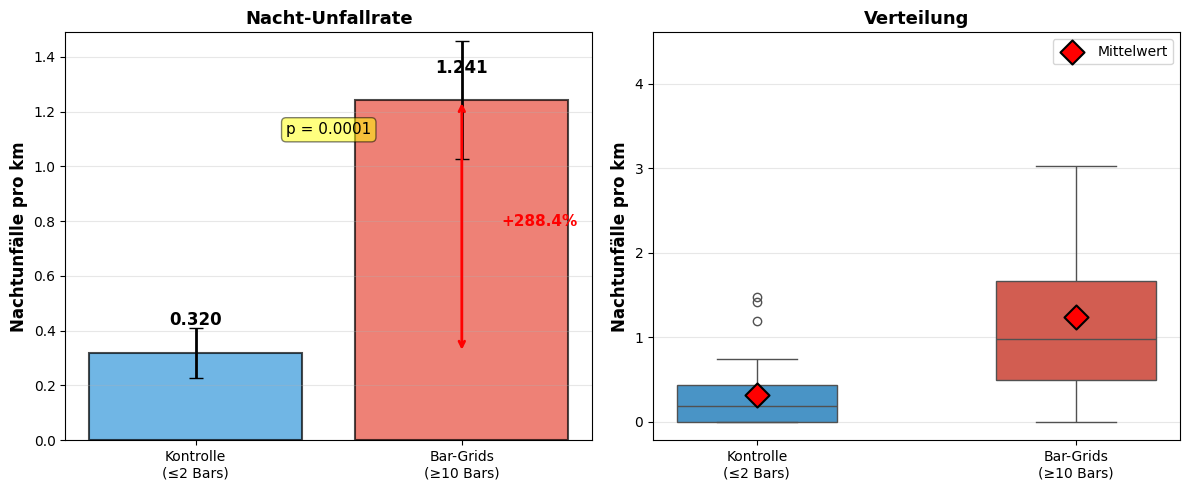

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
means = [ctrl_night.mean(), treat_night.mean()]
labels = ['Kontrolle\n(≤2 Bars)', 'Bar-Grids\n(≥10 Bars)']
colors = ['#3498db', '#e74c3c']

bars = ax1.bar(labels, means, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
sems = [ctrl_night.sem(), treat_night.sem()]
ax1.errorbar(labels, means, yerr=sems, fmt='none', ecolor='black', capsize=5, linewidth=2)

for i, (bar, mean) in enumerate(zip(bars, means)):
    ax1.text(bar.get_x() + bar.get_width()/2, mean + 0.1,
             f'{mean:.3f}', ha='center', fontsize=12, fontweight='bold')

ax1.text(0.5, max(means) * 0.9, f'p = {p_value:.4f}',
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

ax1.annotate('', xy=(1, treat_night.mean()), xytext=(1, ctrl_night.mean()),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax1.text(1.15, (treat_night.mean() + ctrl_night.mean())/2,
         f'+{pct_night:.1f}%', fontsize=11, color='red', fontweight='bold')

ax1.set_ylabel('Nachtunfälle pro km', fontsize=12, fontweight='bold')
ax1.set_title('Nacht-Unfallrate', fontsize=13, fontweight='bold')
ax1.set_ylim(0, max(means) * 1.2)
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
data_for_box = pd.DataFrame({
    'Gruppe': ['Kontrolle\n(≤2 Bars)'] * len(ctrl_night) + ['Bar-Grids\n(≥10 Bars)'] * len(treat_night),
    'Unfallrate': list(ctrl_night) + list(treat_night)
})

sns.boxplot(data=data_for_box, x='Gruppe', y='Unfallrate', ax=ax2,
            palette=['#3498db', '#e74c3c'], width=0.5)

ax2.scatter([0, 1], [ctrl_night.mean(), treat_night.mean()],
           marker='D', s=150, color='red', zorder=5, label='Mittelwert', edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Nachtunfälle pro km', fontsize=12, fontweight='bold')
ax2.set_xlabel('')
ax2.set_title('Verteilung', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Bar-Grids haben knapp 4× so viele Nachtunfälle pro km wie vergleichbare Kontrollgrids (1.24 vs 0.32). Der Unterschied ist hochsignifikant (p = 0.0001).

### Unfalltypen-Vergleich
- Chi²-Test auf Beteiligte, Unfallart (UART) und Unfalltyp (UTYP1)
- Nur gematchte Grids, nur Nachtunfälle

In [25]:
unfaelle_matched = gpd.sjoin(
    nacht_unfaelle,
    grid_gdf[['GridID', 'geometry']],
    how='inner',
    predicate='within'
)

treatment_grids = set(matched_treatment['GridID'])
control_grids = set(matched_control['GridID'])

unfaelle_treatment = unfaelle_matched[unfaelle_matched['GridID'].isin(treatment_grids)]
unfaelle_control = unfaelle_matched[unfaelle_matched['GridID'].isin(control_grids)]

print(f"Nachtunfälle Bar-Grids: {len(unfaelle_treatment)}, Control: {len(unfaelle_control)}")

print("\nBeteiligte")
print(f"{'Typ':<20} {'Bar-Grids':<25} {'Control':<25} {'p-value':<10}")

for col, name in [('IstFuss', 'Fußgänger'), ('IstRad', 'Fahrrad')]:
    n_t = (unfaelle_treatment[col] == 1).sum()
    n_c = (unfaelle_control[col] == 1).sum()
    pct_t = n_t / len(unfaelle_treatment) * 100
    pct_c = n_c / len(unfaelle_control) * 100

    contingency = pd.crosstab(
        pd.concat([unfaelle_treatment, unfaelle_control])['GridID'].isin(treatment_grids),
        pd.concat([unfaelle_treatment, unfaelle_control])[col] == 1
    )
    _, p, _, _ = chi2_contingency(contingency)
    print(f"{name:<20} {n_t} ({pct_t:.1f}%){'':<14} {n_c} ({pct_c:.1f}%){'':<14} {p:.4f}")

uart_labels = {
    0: "Andere Art", 1: "Anfahrend", 2: "Vorausfahrend",
    3: "Seitlich", 4: "Entgegenkommend", 5: "Einbiegend/Kreuzend",
    6: "Fzg-Fußgänger", 7: "Hindernis", 8: "Abkommen rechts", 9: "Abkommen links"
}

contingency_uart = pd.crosstab(
    pd.concat([unfaelle_treatment, unfaelle_control])['GridID'].isin(treatment_grids),
    pd.concat([unfaelle_treatment, unfaelle_control])['UART']
)
_, p_uart, _, _ = chi2_contingency(contingency_uart)

print(f"\nUnfallart (UART) — Chi² p = {p_uart:.4f}")
print(f"{'Code':<6} {'Label':<22} {'Bar-Grids':<25} {'Control':<25}")

for code_val in sorted(set(unfaelle_treatment['UART'].unique()) | set(unfaelle_control['UART'].unique())):
    label = uart_labels.get(code_val, f"Code {code_val}")
    n_t = (unfaelle_treatment['UART'] == code_val).sum()
    n_c = (unfaelle_control['UART'] == code_val).sum()
    pct_t = n_t / len(unfaelle_treatment) * 100
    pct_c = n_c / len(unfaelle_control) * 100
    print(f"{code_val:<6} {label:<22} {n_t} ({pct_t:.1f}%){'':<14} {n_c} ({pct_c:.1f}%)")

utyp_labels = {
    1: "Fahrunfall", 2: "Abbiegeunfall", 3: "Einbiegen/Kreuzen",
    4: "Überschreiten", 5: "Ruhender Verkehr", 6: "Längsverkehr"
}

contingency_utyp = pd.crosstab(
    pd.concat([unfaelle_treatment, unfaelle_control])['GridID'].isin(treatment_grids),
    pd.concat([unfaelle_treatment, unfaelle_control])['UTYP1']
)
_, p_utyp, _, _ = chi2_contingency(contingency_utyp)

print(f"\nUnfalltyp (UTYP1) — Chi² p = {p_utyp:.4f}")
print(f"{'Code':<6} {'Label':<22} {'Bar-Grids':<25} {'Control':<25}")

for code_val in sorted(set(unfaelle_treatment['UTYP1'].unique()) | set(unfaelle_control['UTYP1'].unique())):
    label = utyp_labels.get(code_val, f"Code {code_val}")
    n_t = (unfaelle_treatment['UTYP1'] == code_val).sum()
    n_c = (unfaelle_control['UTYP1'] == code_val).sum()
    pct_t = n_t / len(unfaelle_treatment) * 100
    pct_c = n_c / len(unfaelle_control) * 100
    print(f"{code_val:<6} {label:<22} {n_t} ({pct_t:.1f}%){'':<14} {n_c} ({pct_c:.1f}%)")

Nachtunfälle Bar-Grids: 153, Control: 34

Beteiligte
Typ                  Bar-Grids                 Control                   p-value   
Fußgänger            25 (16.3%)               5 (14.7%)               1.0000
Fahrrad              60 (39.2%)               10 (29.4%)               0.3829

Unfallart (UART) — Chi² p = 0.0019
Code   Label                  Bar-Grids                 Control                  
0      Andere Art             84 (54.9%)               10 (29.4%)
1      Anfahrend              12 (7.8%)               2 (5.9%)
2      Vorausfahrend          3 (2.0%)               6 (17.6%)
3      Seitlich               5 (3.3%)               0 (0.0%)
4      Entgegenkommend        3 (2.0%)               0 (0.0%)
5      Einbiegend/Kreuzend    10 (6.5%)               7 (20.6%)
6      Fzg-Fußgänger          20 (13.1%)               5 (14.7%)
7      Hindernis              3 (2.0%)               1 (2.9%)
8      Abkommen rechts        6 (3.9%)               1 (2.9%)
9      Abkommen links

### Visualisierung
- Love Plot: SMD vor und nach Matching (Ziel: alle Features innerhalb 0.25)
- Paired Dot Plot: Nacht Unfallrate pro Match Paar

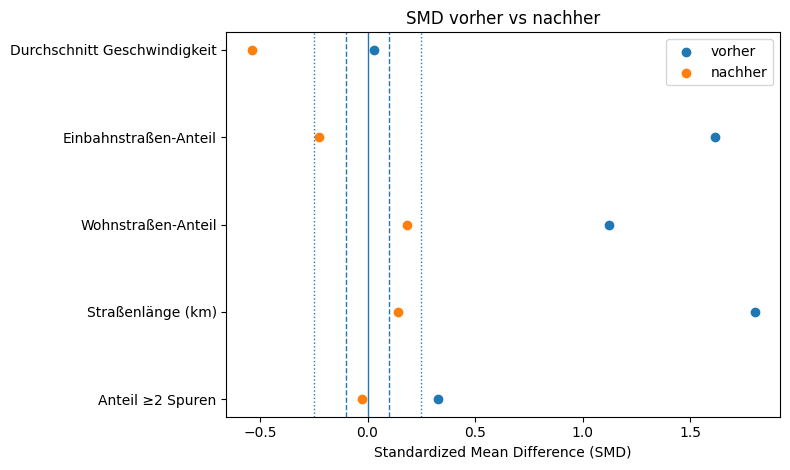

,vorher,nachher
lanes_share_ge2,0.326036,-0.026877
road_km,1.800107,0.140156
residential_km_share,1.120246,0.182815
oneway_km_share,1.615502,-0.227233
maxspeed_mean_weighted,0.030487,-0.538611


In [26]:
feature_names_de = {
    'road_km': 'Straßenlänge (km)',
    'residential_km_share': 'Wohnstraßen-Anteil',
    'maxspeed_mean_weighted': 'Durchschnitt Geschwindigkeit',
    'lanes_share_ge2': 'Anteil ≥2 Spuren',
    'oneway_km_share': 'Einbahnstraßen-Anteil',
}

def _smd(x_t, x_c):
    x_t = pd.to_numeric(x_t, errors="coerce").dropna()
    x_c = pd.to_numeric(x_c, errors="coerce").dropna()
    if len(x_t) == 0 or len(x_c) == 0:
        return np.nan
    pooled_sd = np.sqrt((x_t.var(ddof=1) + x_c.var(ddof=1)) / 2.0)
    return float((x_t.mean() - x_c.mean()) / pooled_sd) if pooled_sd > 0 else 0.0

smd_before = pd.Series({f: _smd(treatment_df[f], control_df[f]) for f in matching_features}, name="vorher")
smd_after = pd.Series({f: _smd(matched_treatment[f], matched_control[f]) for f in matching_features}, name="nachher")

df_smd = pd.concat([smd_before, smd_after], axis=1)
df_smd = df_smd.assign(_abs=df_smd["nachher"].abs()).sort_values("_abs").drop(columns="_abs")
labels_de = [feature_names_de.get(f, f) for f in df_smd.index]

fig, ax = plt.subplots(figsize=(8, 4.8))
y = np.arange(len(df_smd))

ax.scatter(df_smd["vorher"], y, label="vorher")
ax.scatter(df_smd["nachher"], y, label="nachher")

ax.axvline(0, linewidth=1)
ax.axvline(0.1, linestyle="--", linewidth=1); ax.axvline(-0.1, linestyle="--", linewidth=1)
ax.axvline(0.25, linestyle=":", linewidth=1); ax.axvline(-0.25, linestyle=":", linewidth=1)

ax.set_yticks(y)
ax.set_yticklabels(labels_de)
ax.set_xlabel("Standardized Mean Difference (SMD)")
ax.set_title("SMD vorher vs nachher")
ax.legend()
plt.tight_layout()
plt.show()

df_smd

Matching hat die Balance bei 4 von 5 Features auf SMD < 0.25 gebracht. Durchschnittsgeschwindigkeit hat sich durch das Matching verschlechtert (0.03 -> -0.54) – die gematchten Kontrollgrids haben höhere Tempolimits. Die gematchten Kontrollgrids haben höhere Tempolimits.

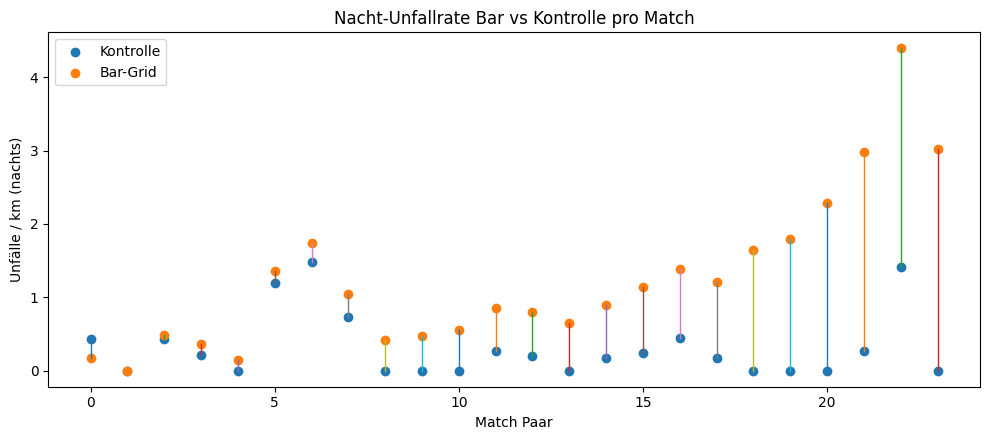

,Diff Nachtunfälle/km (Bar - Kontrolle)
count,24.000000
mean,0.921775
std,0.967507
min,-0.268148
25%,0.234906
50%,0.592599
75%,1.181461
max,3.023179


In [27]:
y_t = pd.to_numeric(matched_treatment["night_rate"], errors="coerce").to_numpy()
y_c = pd.to_numeric(matched_control["night_rate"], errors="coerce").to_numpy()

mask = np.isfinite(y_t) & np.isfinite(y_c)
y_t, y_c = y_t[mask], y_c[mask]

order = np.argsort(y_t - y_c)  # sortiert nach Effekt
y_t, y_c = y_t[order], y_c[order]

fig, ax = plt.subplots(figsize=(10, 4.5))
x = np.arange(len(y_t))

for i in range(len(x)):
    ax.plot([x[i], x[i]], [y_c[i], y_t[i]], linewidth=1)

ax.scatter(x, y_c, label="Kontrolle")
ax.scatter(x, y_t, label="Bar-Grid")

ax.set_xlabel("Match Paar")
ax.set_ylabel("Unfälle / km (nachts)")
ax.set_title("Nacht-Unfallrate Bar vs Kontrolle pro Match")
ax.legend()
plt.tight_layout()
plt.show()

pd.Series(y_t - y_c, name="Diff Nachtunfälle/km (Bar - Kontrolle)").describe()

In fast allen Paaren liegt die Bar Unfallrate über der Kontrolle. Der Effekt ist kein Ausreißer Phänomen - selbst das 25%-Quartil der Differenz liegt bei +0.23 Unfälle/km.